In [1]:
import numpy as np
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.image import ImageDataGenerator
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn
from sklearn.metrics import roc_curve, auc, confusion_matrix


def escape():
    sys.exit()

config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 

Using TensorFlow backend.


# Data Preparation

In [2]:
import_directory = "./Database2/"
counter = 0
data_array = np.empty((0, 2))
files = os.listdir(import_directory)
for file in files:
    print('Opening File : ', file)
    data_set = np.load(import_directory+file, allow_pickle=True)
    data_array = np.vstack((data_array, data_set))

#separated = np.array([x for x in data_array if x[1] == 0])

Opening File :  destinationPayload_TestbedWedJun16-1Flows.xml.npy
Opening File :  destinationPayload_TestbedMonJun14Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-2Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-3Flows.xml.npy
Opening File :  destinationPayload_TestbedThuJun17-2Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-2Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-1Flows.xml.npy
Opening File :  destinationPayload_TestbedSunJun13Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-3Flows.xml.npy
Opening File :  destinationPayload_TestbedSatJun12Flows.xml.npy
Opening File :  destinationPayload_TestbedThuJun17-3Flows.xml.npy


In [3]:
np.random.seed(2019)
np.random.shuffle(data_array)
print("ok")

ok


In [4]:
img_row = 50
img_col = 50

N = np.shape(data_array)[0]
train_test_split_percentage = 0.8

X_train = data_array[:int(N * train_test_split_percentage), 0]
X_test = data_array[int(N * train_test_split_percentage):, 0]

X_train = np.array([x.reshape(img_row, img_col, 3) for x in X_train])
X_test = np.array([x.reshape(img_row, img_col, 3) for x in X_test])

# Compact data
img_row_comp = 32
img_col_comp = 32

X_train = X_train[:, :img_row_comp, :img_col_comp, :]
X_test = X_test[:, :img_row_comp, :img_col_comp, :]

In [5]:
y_train = data_array[:int(N * train_test_split_percentage), 1]
y_test = data_array[int(N * train_test_split_percentage):, 1]

y_train = np.array([[x] for x in y_train])
y_test = np.array([[x] for x in y_test])

In [6]:
del data_array
import gc
gc.collect()

0

In [7]:
print(X_train.shape, X_test.shape)

(642236, 32, 32, 3) (160559, 32, 32, 3)


(array([611841.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  30395.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

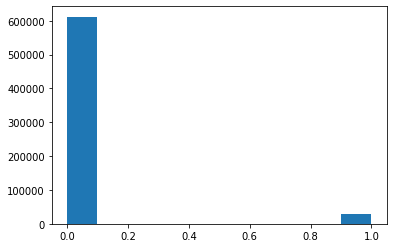

In [23]:
plt.hist(y_train.flatten())

In [ ]:
plt.hist(y_test.flatten())

In [43]:
573612+191100

764712

In [44]:
28484+9599

38083

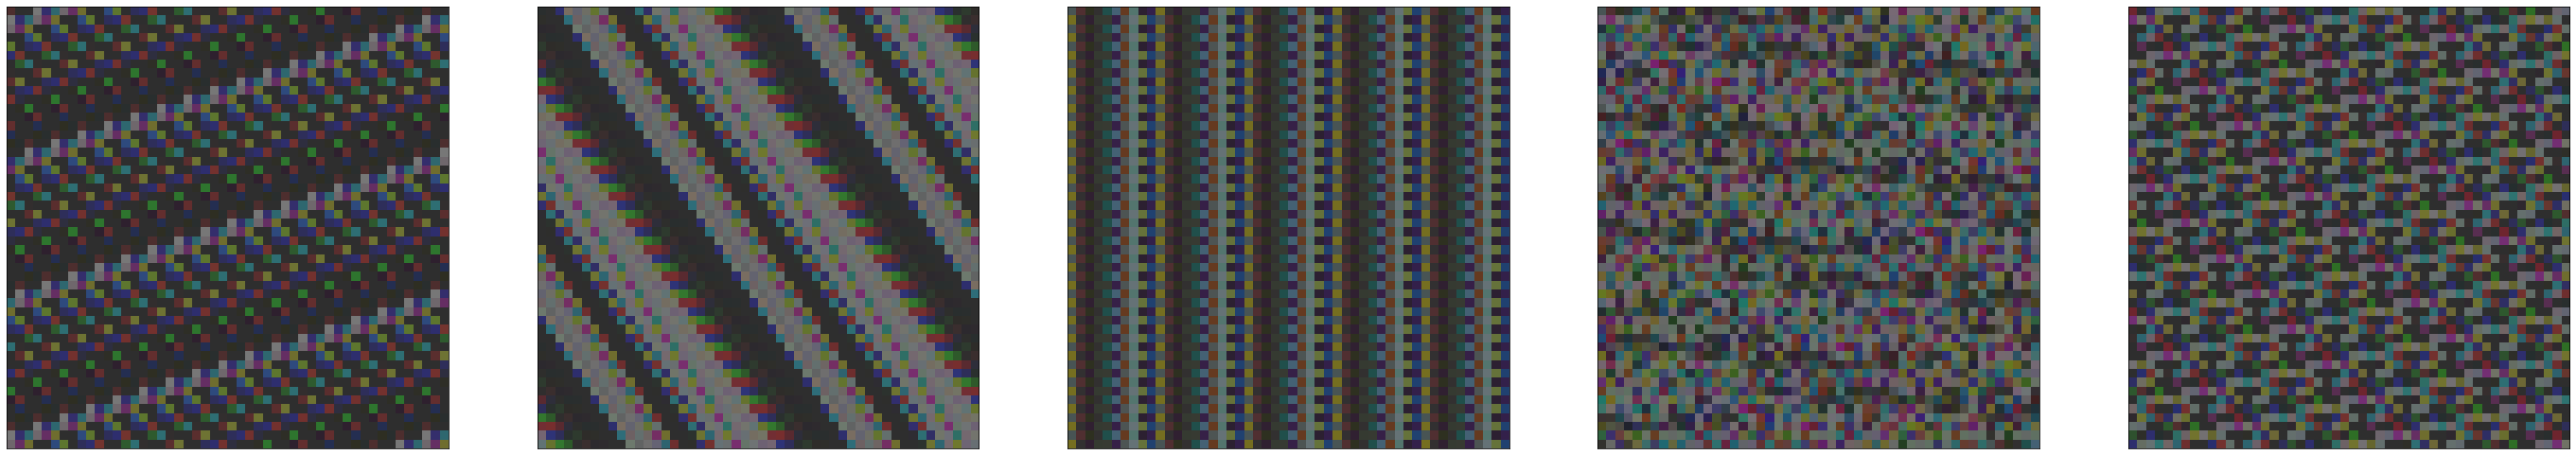

In [14]:
#ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(400, 150))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

# Model Design

In [7]:
from keras.layers import Input,Conv2D,BatchNormalization,Activation,MaxPool2D,merge,Flatten,Dense,GlobalAveragePooling2D,Dropout

def ID_Light_Model(input_shape):
    '''Light weight model for ID.'''
    
    model_input = Input(shape=input_shape) # bz,32,32,3 # channel-last format

    x = Conv2D(12, (5, 5), strides=1, padding='same')(model_input)
    x = BatchNormalization(axis=-1)(x) #bn_conv1
    x = Activation('relu')(x) #conv1_relu

    x = Conv2D(12, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = MaxPool2D(pool_size=2)(x) # bz,16,16,12
    
    x = Conv2D(24, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    # Dilated CNN
    x = Conv2D(48, (3, 3), strides=2, padding='same')(x) # 8
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(48, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.4)(x)
    x = Dense(256, activation=None)(x)
    x = keras.layers.PReLU()(x)
    x = Dropout(rate=0.4)(x)
    #x = BatchNormalization()(x)
    out_sigmoid = Dense(1, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=model_input, outputs=out_sigmoid)

    return model

In [8]:
model = ID_Light_Model(input_shape=(32,32,3))
# Compile model for training
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

batch_size = 64
epochs = 3

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 12)        912       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 12)        48        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 12)        1308      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 12)        48        
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 12)        0         
__________

# Training

In [16]:
hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 513788 samples, validate on 128448 samples
Epoch 1/3
513788/513788 [==============================] - 67s 131us/step - loss: 0.0354 - acc: 0.9905 - val_loss: 0.7606 - val_acc: 0.9525
Epoch 2/3
513788/513788 [==============================] - 66s 129us/step - loss: 0.0333 - acc: 0.9909 - val_loss: 0.0304 - val_acc: 0.9912
Epoch 3/3
513788/513788 [==============================] - 66s 129us/step - loss: 0.0332 - acc: 0.9910 - val_loss: 0.0323 - val_acc: 0.9912


In [19]:
model.save("ID_Light_Final.hdf5")

# Evaluation

## AUC

In [17]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

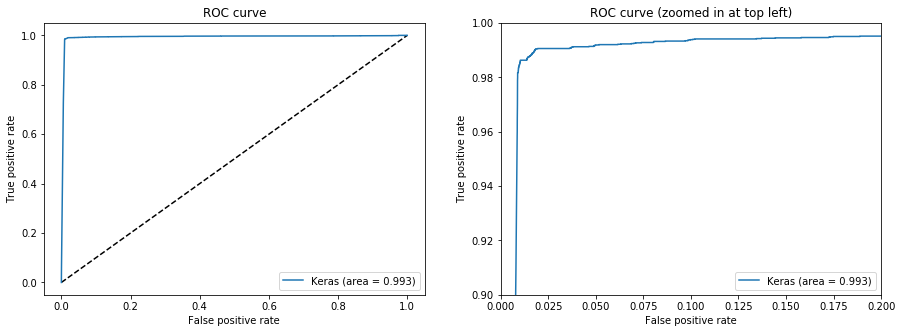

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


# Zoom in view of the upper left corner.
plt.subplot(122)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

## Plot loss curves

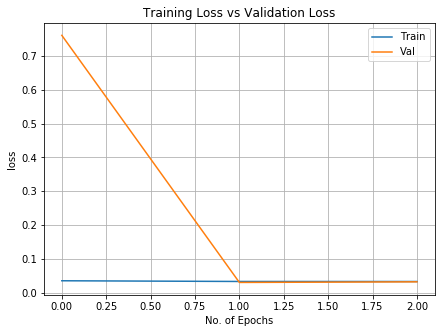

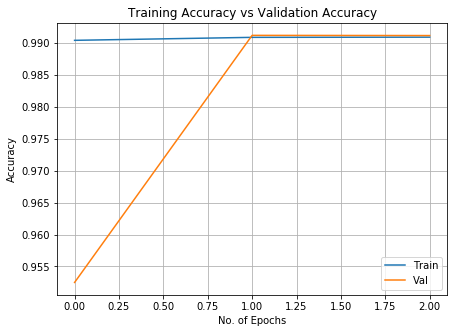

In [20]:
training_loss= hist.history['loss']
val_loss= hist.history['val_loss'] 
training_acc= hist.history['acc'] 
val_acc= hist.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5)) 
plt.plot(xc,training_loss)
plt.plot(xc,val_loss) 
plt.xlabel('No. of Epochs') 
plt.ylabel('loss') 
plt.title('Training Loss vs Validation Loss') 
plt.grid(True) 
plt.legend(['Train','Val'])

plt.figure(2,figsize=(7,5)) 
plt.plot(xc,training_acc) 
plt.plot(xc,val_acc) 
plt.xlabel('No. of Epochs') 
plt.ylabel('Accuracy') 
plt.title('Training Accuracy vs Validation Accuracy') 
plt.grid(True) 
plt.legend(['Train','Val'],loc=4)

total length =  160559
Anomolies =  7670
Normal =  152889


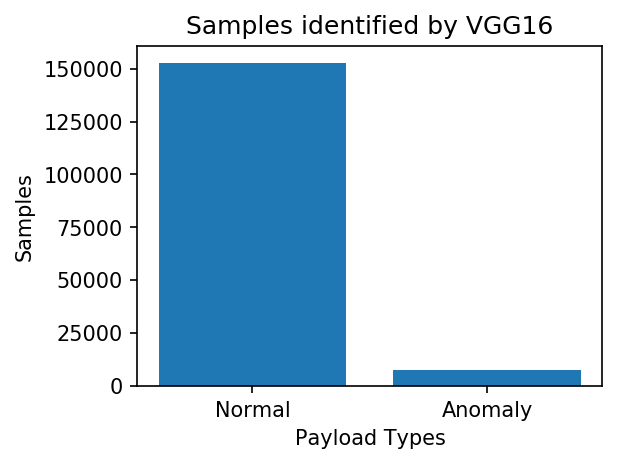

In [28]:
checking_occurences = [x for x in y_test if x == 1]
print("total length = ",len(y_test))
print("Anomolies = ",len(checking_occurences))
print("Normal = ", (len(y_test) - len(checking_occurences)))

n = len(y_test) - len(checking_occurences)
a = len(checking_occurences)

label = ['Normal', 'Anomaly']
samples = [n, a]

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi * 1.5

# this is for plotting purpose
index = np.arange(len(label))
plt.figure(figsize=(4,3))
plt.bar(index, samples)
plt.xlabel('Payload Types', fontsize=10)
plt.ylabel('Samples', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=0)
plt.title('Samples identified by VGG16')
plt.show()

In [35]:
predictions = model.predict(X_test)
print("Predictions = ",predictions)

Predictions =  [[4.2257004e-15]
 [3.8418132e-13]
 [8.6900288e-01]
 ...
 [1.0172349e-11]
 [1.3376259e-17]
 [1.1790138e-08]]


In [36]:
rounded = [[round(x[0])] for x in predictions]
from sklearn.metrics import f1_score
result = f1_score(y_test,rounded, average=None, labels = [0,1])
print("F1 = ",result)

F1 =  [0.99502559 0.90850897]


In [39]:
import sklearn.metrics
target_names = ['Normal','Malicious']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    152889
   Malicious       0.85      0.98      0.91      7670

    accuracy                           0.99    160559
   macro avg       0.92      0.99      0.95    160559
weighted avg       0.99      0.99      0.99    160559



In [50]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [63]:
cm.ravel

numpy.ndarray

In [64]:
cm = confusion_matrix(y_test, rounded, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

In [65]:
cm

array([[151522,   1367],
       [   148,   7522]])

In [66]:
print('tn: {:d}, fp {:d}, fn {:d}, tp {:d}'.format(tn, fp, fn, tp))

tn: 151522, fp 1367, fn 148, tp 7522


In [1]:
(151522+7522)/(151522+7522+148+1367)

0.9905642162694087

In [51]:
cm_df = pd.DataFrame(cm,
                     index = ['Normal', 'Malicious'], 
                     columns = ['Normal', 'Malicious'])

In [59]:
cm_df

,Normal,Malicious
Normal,151522,1367
Malicious,148,7522


Text(0.5, 69.58333333333334, 'Predicted label')

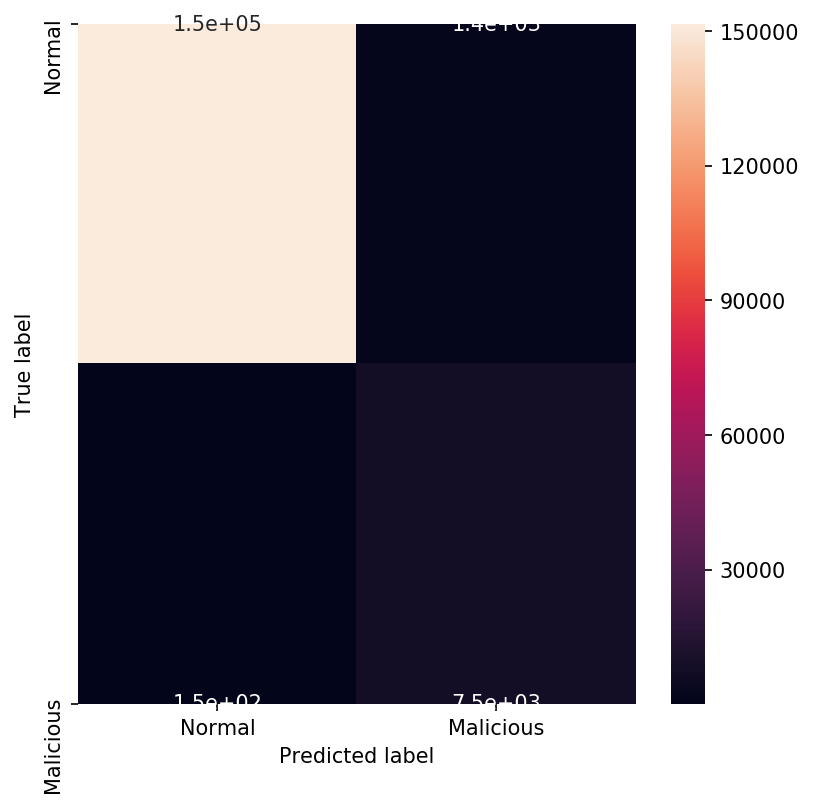

In [67]:
plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Data Augmentation

In [34]:
del train_datagen, train_generator
gc.collect()

390

In [35]:
#train_datagen = ImageDataGenerator(brightness_range=[0.9,1.1], rotation_range=10, fill_mode='reflect')
train_datagen = ImageDataGenerator(rotation_range=10, fill_mode='reflect')
#valid_datagen = ImageDataGenerator() # RAM not enough. So ignore

In [36]:
#train_generator = train_datagen.flow(X_train, y=y_train, batch_size=batch_size)
train_generator = train_datagen.flow(X_train, y=y_train, batch_size=512)

In [ ]:
valid_generator = valid_datagen.flow(X_test, y=y_test, batch_size=batch_size)

In [27]:
X_test[0,:,:,:]

array([[[ 72,  84,  84],
        [ 80,  47,  49],
        [ 46,  49,  32],
        ...,
        [101, 110, 116],
        [108, 121,  68],
        [ 97, 116, 101]],

       [[110, 116, 108],
        [121,  68,  97],
        [116, 101,  58],
        ...,
        [ 48,  32,  49],
        [ 52,  58,  50],
        [ 48,  58,  51]],

       [[ 32,  49,  52],
        [ 58,  50,  48],
        [ 58,  51,  49],
        ...,
        [118, 101, 100],
        [ 32,  80, 101],
        [114, 109,  97]],

       ...,

       [[ 48,  49,  32],
        [ 77, 111, 118],
        [101, 100,  32],
        ...,
        [ 32,  77, 111],
        [110,  44,  32],
        [ 49,  52,  32]],

       [[ 77, 111, 110],
        [ 44,  32,  49],
        [ 52,  32,  74],
        ...,
        [ 32,  72,  84],
        [ 84,  80,  47],
        [ 49,  46,  49]],

       [[ 72,  84,  84],
        [ 80,  47,  49],
        [ 46,  49,  32],
        ...,
        [101, 110, 116],
        [108, 121,  68],
        [ 97, 116, 101]]

(array([123643., 494358., 112439.,  61457.,  64066.,  67930.,  64841.,
        216123., 317819.,  50188.]),
 array([ 32. ,  41.5,  51. ,  60.5,  70. ,  79.5,  89. ,  98.5, 108. ,
        117.5, 127. ]),
 <a list of 10 Patch objects>)

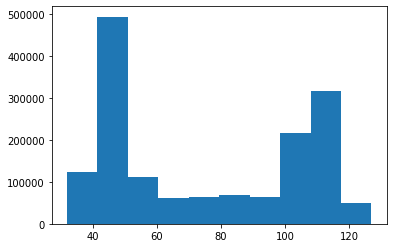

In [33]:
plt.hist(X_test[0:512,:,:,:].flatten())

In [41]:
tmp = train_generator.next()

In [42]:
tmp[0][0,:,:,:].flatten()

array([ 85.07033,  94.63987, 101.54683, ...,  55.87115,  40.64143,
        66.46958], dtype=float32)

(array([ 32293., 319390., 203251., 181804., 181194., 167691., 164328.,
        197726., 119004.,   6183.]),
 array([ 32.      ,  41.42819 ,  50.856377,  60.284565,  69.71275 ,
         79.140945,  88.56913 ,  97.997314, 107.42551 , 116.8537  ,
        126.28188 ], dtype=float32),
 <a list of 10 Patch objects>)

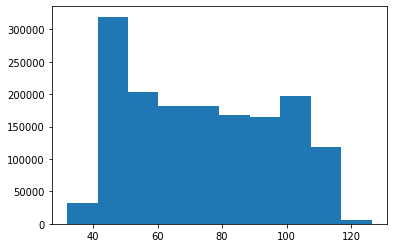

In [43]:
plt.hist(tmp[0][:,:,:,:].flatten())

Text(0.5, 1.0, 'Distribution of pixel values after augmented.')

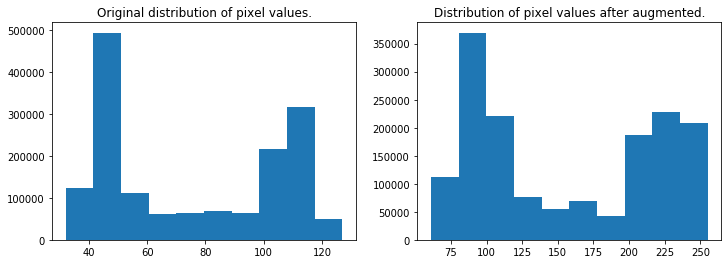

In [40]:
# Original distribution and Random value shift result
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(X_test[0:512,:,:,:].flatten())
plt.title('Original distribution of pixel values.')

plt.subplot(122)
plt.hist(tmp[0][:,:,:,:].flatten())
plt.title('Distribution of pixel values after augmented.')

Text(0.5, 1.0, 'Distribution of pixel values after rotation.')

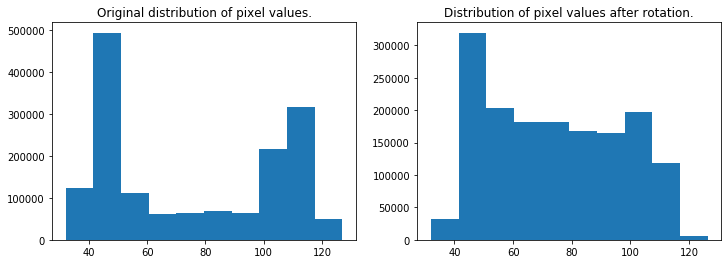

In [44]:
# Original distribution and rotation result
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(X_test[0:512,:,:,:].flatten())
plt.title('Original distribution of pixel values.')

plt.subplot(122)
plt.hist(tmp[0][:,:,:,:].flatten())
plt.title('Distribution of pixel values after rotation.')

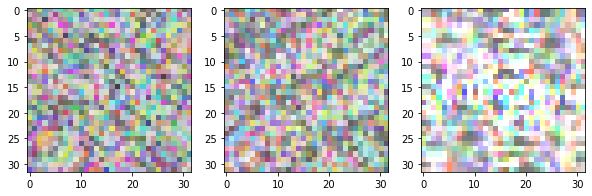

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):
	# define subplot
	plt.subplot(130 + 1 + i)
	# generate batch of images
	img_batch = train_generator.next()
	# convert to unsigned integers for viewing
	image = img_batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [13]:
history_tl = model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    #steps_per_epoch = 513788,
    #samples_per_epoch=nb_train_samples,
    #validation_data=validation_generator,
    validation_data=None,
    shuffle=True,
    #class_weight='auto')
    class_weight=None)

Epoch 1/3
   7/1255 [..............................] - ETA: 2:28:31 - loss: 0.3668 - acc: 0.8594

/home/reck/anaconda2/envs/dev-reck-py36/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144403). Check your callbacks.
  % delta_t_median)


1255/1255 [==============================] - 343s 273ms/step - loss: 0.0345 - acc: 0.9890
Epoch 2/3
1255/1255 [==============================] - 297s 236ms/step - loss: 0.0294 - acc: 0.9909
Epoch 3/3
1255/1255 [==============================] - 297s 236ms/step - loss: 0.0288 - acc: 0.9910


In [17]:
tmp=train_generator.next()

In [21]:
tmp[0].shape

(512, 32, 32, 3)

## AUC

In [14]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

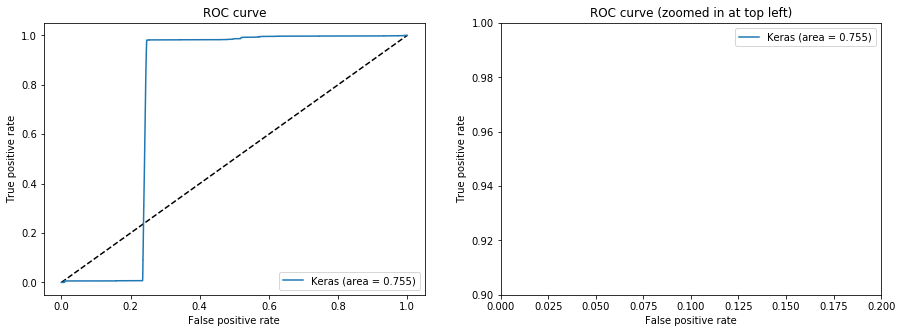

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


# Zoom in view of the upper left corner.
plt.subplot(122)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

In [16]:
rounded = [round(x) for x in y_pred_keras]

cm = confusion_matrix(y_test, rounded, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print(cm)
print('tn: {:d}, fp {:d}, fn {:d}, tp {:d}'.format(tn, fp, fn, tp))
target_names = ['Normal','Malicious']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

[[152953      0]
 [  7606      0]]
tn: 152953, fp 0, fn 7606, tp 0
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.98    152953
   Malicious       0.00      0.00      0.00      7606

    accuracy                           0.95    160559
   macro avg       0.48      0.50      0.49    160559
weighted avg       0.91      0.95      0.93    160559



/home/reck/anaconda2/envs/dev-reck-py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/reck/anaconda2/envs/dev-reck-py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/reck/anaconda2/envs/dev-reck-py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
